In [1]:
from mlip_arena.tasks import MD, PHONON, OPT
from mlip_arena.tasks.utils import get_calculator
from ase.build import bulk
from ase.io import read
import numpy as np

atoms = read('BZO_cubic_prim.xyz')

/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
2025-03-18 22:33:32.183 | WARNING  | mlip_arena.models:<module>:34 - No module named 'deepmd'


In [ ]:
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
from ase.io import write

from ase.calculators.vasp import Vasp

replicas = (2, 2, 2)

atoms = read('BZO_cubic_prim.xyz')
atoms.set_cell(cell=[4.0, 4.0, 4.0], scale_atoms=True)
atoms.set_constraint()

calc = Vasp(
    kpts=(3, 3, 3),
    xc='PBE',
    encut=500,
    ediff=1e-7,
    ibrion=-1,
    ismear=0,
    sigma=0.01,
    isif=2,
    isym=0,
    nsw=0,
    lreal=False,
    lwave=False,
    lcharg=False,
    lmaxmix=4,
    command='vasp_std',
    directory='pbe',
)

atoms = OPT(
    atoms=atoms,
    calculator=calc,
    optimizer="FIRE2",
    # filter="FrechetCell",
    criterion=dict(fmax=1e-3),
    symmetry=True,
)["atoms"]

atoms.set_constraint()

result = PHONON(
    atoms=atoms.copy(),
    calculator=calc,
    supercell_matrix=np.eye(3) * 2,
    distance=0.01,
)

22:33:35.208 | INFO    | prefect - Starting temporary server on http://127.0.0.1:8224
See https://docs.prefect.io/3.0/manage/self-host#self-host-a-prefect-server for more information on running a dedicated Prefect server.

22:33:41.734 | INFO    | Task run 'OPT: BaO3Zr - <ase.calculators.vasp.vasp.Vasp object at 0x7f582ccbee10>' - Finished in state Cached(type=COMPLETED)

22:33:41.851 | INFO    | Task run 'get_phonopy' - Finished in state Completed()

/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  

22:38:40.064 | INFO    | Task run 'PHONON: BaO3Zr - <ase.calculators.vasp.vasp.Vasp object at 0x7f582ccbee10>' - Finished in state Completed()

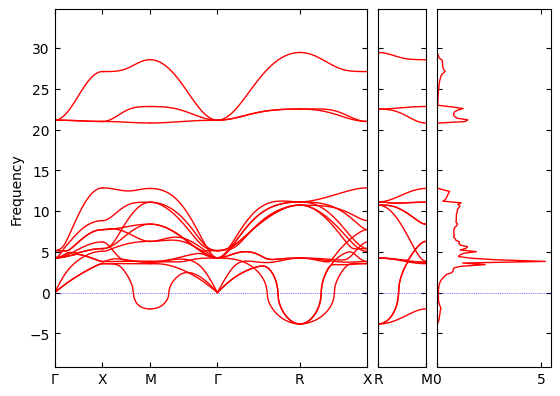

In [18]:
from matplotlib import pyplot as plt

phonon = result['phonon']
phonon.save(settings={'force_constants': True}, filename='pbe/phonopy_params.yaml')

with plt.style.context("default"):


    phonon.plot_band_structure_and_dos()
    
    plt.savefig('pbe/band_structure.png', dpi=300)
    plt.show()

0 -3.852752827221051


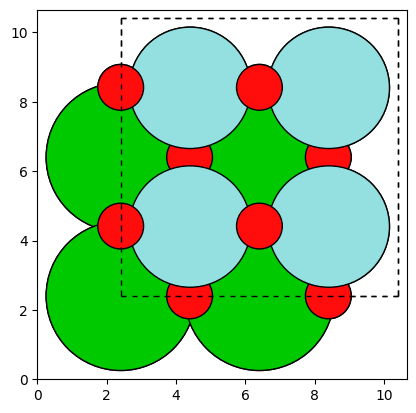

1 -3.852752827221041


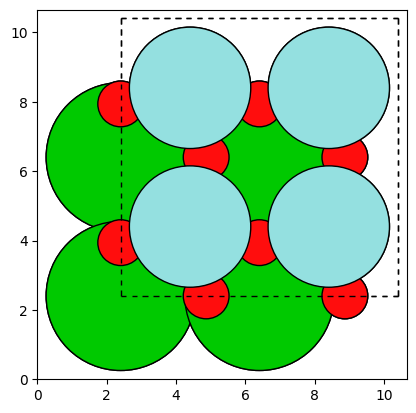

2 -3.852752827221033


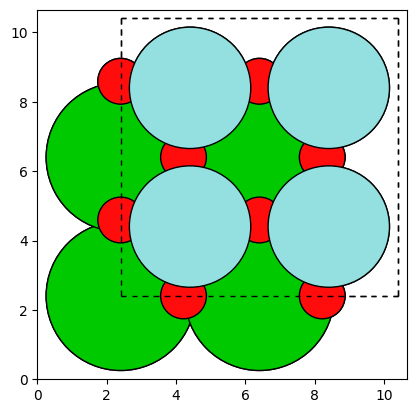

3 4.239601372763498
4 4.2396013727635
5 4.239601372763502
6 10.741792762297127
7 10.741792762297136
8 10.74179276229714
9 11.135561953696916
10 11.135561953696929
11 11.135561953696929
12 22.53713229271336
13 22.537132292713366
14 29.48031578745088


In [30]:
%matplotlib inline


freqs, eigvecs = phonon.get_frequencies_with_eigenvectors(q=[0.5, 0.5, 0.5])

# write("undeformed.extxyz", atoms * (2, 2, 2))

for mode in range(len(eigvecs)):
    # mode = 0
    eigvec = eigvecs[:, mode].real.reshape(-1, 3)

    # atoms = read('BZO_cubic_prim.xyz')
    cloned = atoms.copy() #* replicas
    norm_eigvec = eigvec / np.linalg.norm(eigvec, axis=1).max() * 0.5
    cloned.positions += norm_eigvec
    cloned.set_constraint()

    print(mode, freq := freqs[mode])

    if freq >= 0:
        continue
        
    # view(atoms * (5, 5, 5), viewer='x3d')

    plot_atoms(cloned * (2, 2, 2))
    write(f"pbe/mode-{mode}.extxyz", cloned * (2, 2, 2))
    plt.savefig(f"pbe/mode-{mode}.png", dpi=300)
    plt.show()

In [ ]:
mode = 1
eigvec = eigvecs[:, mode].real.reshape(-1, 3)

norm_eigvec = eigvec / np.linalg.norm(eigvec, axis=1).max() * 0.5
print(norm_eigvec)

np.save(f'pbe/mode-{mode}.npy', eigvec)

[[-2.11439178e-18 -4.22304315e-17 -5.70003002e-16]
 [-1.91068525e-17  6.38796468e-17 -3.43967329e-17]
 [ 1.65178706e-02  1.86479850e-01 -6.38796468e-17]
 [ 4.63923771e-01 -2.70260044e-17 -1.86479850e-01]
 [ 9.68175896e-17 -4.63923771e-01 -1.65178706e-02]]
